In [1]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()
model = ChatOpenAI(model='gpt-4o-mini')

In [3]:
class ChatState(MessagesState):
    summary: str

In [8]:
def summarize_node(state: ChatState):
    existing_summary = state['summary']
    
    if existing_summary:
        prompt =(
            f"Existing Summary:\n{existing_summary}\n\n"
            "Extend the summary with the new conversation:"
        )
    else:
        prompt = (
            "Create a summary of the conversation above:"
        )
   
    message_for_summary = state["messages"] + [HumanMessage(content=prompt)]
    response = model.invoke(message_for_summary)
   
    message_to_delete = state["messages"][:-2]
    return {
       "summary": response.content,
       "messages": [RemoveMessage(id=m.id) for m in message_to_delete],
   }
    

In [4]:
def chat_node(state: ChatState):
    messages = []
    if state['summary']:
        messages.append({
            "role": "system",
            "content": f"Conversation Summary:\n{state['summary']}"
            
        })
    messages.extend(state['messages'])
    print(messages)
    response = model.invoke(messages)
    return { "messages": [response]}

In [10]:
def should_summarize(state: ChatState):
    return len(state['messages']) > 6

In [11]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_node)

builder.add_edge(START, "chat")
builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: END,
    }
)
builder.add_edge("summarize", END)



In [13]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

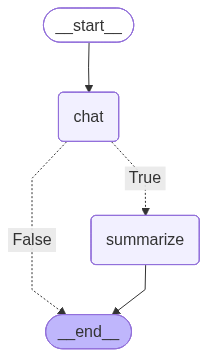

In [14]:
graph

In [15]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [16]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [17]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='c9c7651d-ac57-4eb1-aa7b-9305ff69abb2')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, or quantum mechanics, is a fundamental theory in physics that d


In [18]:
run_turn('What is LangGraph?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='c9c7651d-ac57-4eb1-aa7b-9305ff69abb2'), AIMessage(content='Quantum physics, or quantum mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. Here are some key concepts and principles of quantum physics:\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons and photons, exhibit both wave-like and particle-like behavior. This means that they can sometimes behave like particles (localized in space) and sometimes like waves (spread out over a region).\n\n2. **Quantum Superposition**: A quantum system can exist in multiple states at once until it is measured. This phenomenon is famously illustrated by Schrödinger\'s cat thought experiment, where a cat in a sealed box can be both alive and dead until someone opens the box and observes it.\n\n3. **Quantum Entanglement**: Particles can become entangled, me

In [19]:
run_turn('What is 5 * 10')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='c9c7651d-ac57-4eb1-aa7b-9305ff69abb2'), AIMessage(content='Quantum physics, or quantum mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. Here are some key concepts and principles of quantum physics:\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons and photons, exhibit both wave-like and particle-like behavior. This means that they can sometimes behave like particles (localized in space) and sometimes like waves (spread out over a region).\n\n2. **Quantum Superposition**: A quantum system can exist in multiple states at once until it is measured. This phenomenon is famously illustrated by Schrödinger\'s cat thought experiment, where a cat in a sealed box can be both alive and dead until someone opens the box and observes it.\n\n3. **Quantum Entanglement**: Particles can become entangled, me

In [20]:
run_turn('Explain Deep Learning')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='c9c7651d-ac57-4eb1-aa7b-9305ff69abb2'), AIMessage(content='Quantum physics, or quantum mechanics, is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. Here are some key concepts and principles of quantum physics:\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons and photons, exhibit both wave-like and particle-like behavior. This means that they can sometimes behave like particles (localized in space) and sometimes like waves (spread out over a region).\n\n2. **Quantum Superposition**: A quantum system can exist in multiple states at once until it is measured. This phenomenon is famously illustrated by Schrödinger\'s cat thought experiment, where a cat in a sealed box can be both alive and dead until someone opens the box and observes it.\n\n3. **Quantum Entanglement**: Particles can become entangled, me